**Important**: The interactive features of this notebook don't work in Kaggle's *Reader* mode. They only work in *Edit* mode. Therefore, before starting reading this, please click "**Copy & Edit**" in the top right of this window, then in the menu click *Run* and then *Run all*. Then you'll be able to use all the interactive sliders in this notebook.

## Fitting a function with *gradient descent*

A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1. Multiplies each input by a number of values. These values are known as *parameters*
1. Adds them up for each group of values
1. Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore, a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using *gradient descent*. Let's see how this works...

In [ ]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

Let's plot $3x^2+2x+1 $ quadratic function using `plot_function`

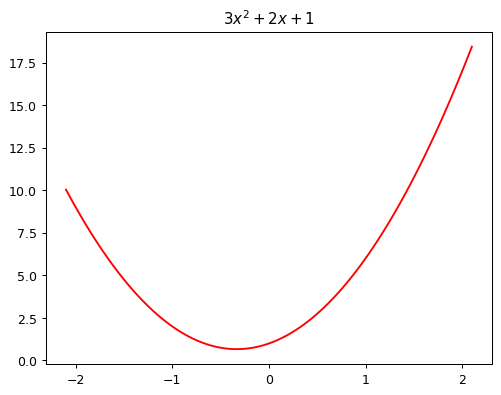

In [ ]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

Define quadratic as : $ Ax^2 + Bx + C $ as we learned in school

In [ ]:
def quad(a, b, c, x): return a*x**2 + b*x + c

To fix values passed to a function in python, we use `partial` function.

In [ ]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

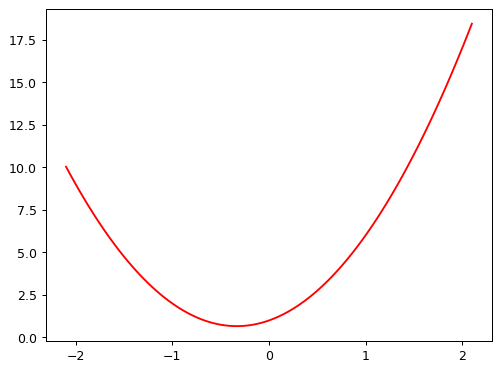

In [ ]:
f2 = mk_quad(3,2,1)
plot_function(f2)

Now, let's add some noise to our measurements of quadratic.

In [ ]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [ ]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

Lets see our noise

In [ ]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

As we can see, they're tensors. A tensor is just like an `array` in NumPy \
Let's take a look at the plot

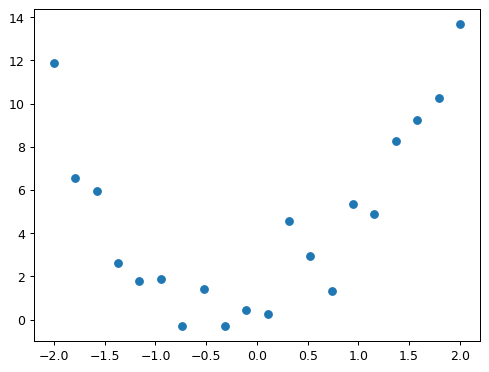

In [ ]:
plt.scatter(x,y);

Now using `@interact` we are trying to fit the function to our noised data

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

As a human we can kinda fit the function just by looking at it but for the computer to know if it's making progress we need to create `loss` function, in the cell above we create a simple `mae` (mean absolute error) function to calculator the loss

In [ ]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

Now fit the graph again with loss function displayed

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automating gradient descent

This simple Quadratic only has 3 parameters, but in a mordern neural network we will find often tens of milions of parameters to fit. We wont be albe to do that by hand so we need to automate the process.

To do this, we will find the gradient of `mae()` for each of our parameters, and then adjust our parameters. \
To do this, we need a function that takes parameters `a`, `b`, `c` as a singe vector and returns `mae()`

In [ ]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

Let's try it:

In [ ]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

In [ ]:
abc = torch.tensor([1.1,1.1,1.1])
abc

tensor([1.1000, 1.1000, 1.1000])

Now how do we update the parameters we will use a magic of gradients, lucky we don't need to calculate them by hand ^^, we don't even need to create a function since `pytoch` has a way to calculate them for us. \
To tell PyTorch we want to calculate gradients for these parameters, we need to call `requires_grad_()`

In [ ]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

Now we can calculate `mae()`

In [ ]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

To get PyTorch to calculate the gradients, we just need to call `backwards()`

In [ ]:
loss.backward()

Now let's see our gradients, there will be stored in an attribute called `grad`

In [ ]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

According to these gradients, our parameters are a little low. Let's increase them a bit. If we subtract the gradient, multiplied by a small number later known as `LearningRate`, that should improve Them

In [ ]:
with torch.no_grad():
    abc -= abc.grad*0.01 # This number is basicly Larning Rate
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=2.40


**Jeremy's NOTE**\
BTW, you'll see we had to wrap our calculation of the new parameters in with torch.no_grad(). That disables the calculation of gradients for any operations inside that context manager. We have to do that, because abc -= abc.grad*0.01 isn't actually part of our quadratic model, so we don't want derivatives to include that calculation.

Nice our loss already dropped now let's do it more times

In [ ]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


Our loss dropped a lot, if we would keep running this loop for long enough, you'll see the loss eventually start increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump over the correct answer! To avoid this, we need to decrease our `learning rate` as we train. This is done using `learning rate schedule` and can be automated in most deep learning frameworks.

In [ ]:
abc

tensor([1.9634, 1.1381, 1.4100], requires_grad=True)

## How a neural network approximates any given function

The way a neural network approximates a any function turns out to be very simple. The key is using the`RELU` which is basically a linear function as u can see from code $y = mx * b$, but we change all negative numbers to 0, with we do with `troch.clip(y,0.)`

In [ ]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

Here's what it looks like:

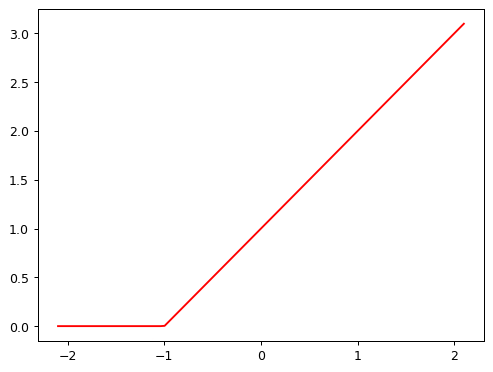

In [ ]:
plot_function(partial(rectified_linear, 1,1))

Instead of `torch.clip(y,0.)` we can instead use `F.relu(x)` which does exactly the same thing. In PyTorch, `F`, refers to the `torch.nn.functional` module.

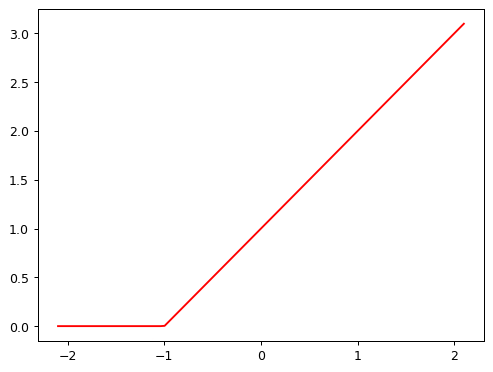

In [ ]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

To understand how `RELU` works/moves, try using interact, where `m` is the slope and `b` changes where the "hook" appears

In [ ]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

The function doesn't do much on its own, but look what happens when we add two of them

In [ ]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

If you play around with that for a while, you notice something quite profound: with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! Any time the function doesn't quite match, you can just add a few more additions to the mix to make it a bit closer.

## How to recognise an owl

OK great, we've created a nifty little example showing that we can drawing squiggly lines that go through some points. So what?

Well... the truth is that actually drawing squiggly lines (or planes, or high-dimensional hyperplanes...) through some points is literally *all that deep learning does*! If your data points are, say, the RGB values of pixels in photos of owls, then you can create an owl-recogniser model by following the exact steps above.

This may, at first, sound about as useful as the classic "how to draw an owl" guide:

![image.png](https://i.pinimg.com/originals/72/29/5c/72295c2669305944b919e6320d436617.jpg)

Good read note from Jeremy

Students often ask me at this point, "OK Jeremy, but how do neural nets *actually work*". But at a foundational level, there is no "step 2". We're done -- the above steps will, given enough time and enough data, create (for example) an owl recognizer, if you feed in enough owls (and non-owls).

The devil, I guess, is in the "given enough time and enough data" part of the above sentence. There's a *lot* of tweaks we can make to reduce both of these things. For instance, instead of running our calculations on a normal CPU, as we've done above, we could do thousands of them simultaneously by taking advantage of a GPU. We could greatly reduce the amount of computation and data needed by using a convolution instead of a matrix multiplication, which basically means skipping over a bunch of the multiplications and additions for bits that you'd guess won't be important. We could make things much faster if, instead of starting with random parameters, we start with parameters of someone else's model that does something similar to what we want (this is called *transfer learning*).

And, of course, there's lots of helpful software out there to do this stuff for you without too much fuss. Like, say, [fastai](https://docs.fast.ai).

Learning these things is what we teach in our [course](https://course.fast.ai), which, like everything we make, is totally free. So if you're interested in learning more, do check it out!